In [1]:
%matplotlib inline

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [4]:
targetDir = "../data/output/d4/Result/"
speedDir = "../data/output/d4/Speed/"
brakeDir = "../data/output/d4/Brake/"
accelDIr = "../data/output/d4/Accel/"
steeringPositiveDir = "../data/output/d4/SteeringPositive/"
steeringNegativeDir = "../data/output/d4/SteeringNegative/"
aheadDistance = "../data/output/d4/AheadDistance/"

In [5]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(aheadDistance + "result.csv")
df6.columns = [["id", "near", "intermediate", "far"]]

In [6]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(df, df6, on="id")
gridSize = len(df)

In [7]:
features =  ["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far"]

In [8]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "yellow", "green", "stop", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far"]]
mf.columns = features

In [9]:
mf.describe()

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,31.973384,89.064639,58.361217,109.110266,5.000000,6.087452,27.414449,12.775665,167.262357,78.669202,42.577947
std,44.534694,89.638330,88.349080,215.273675,7.141963,7.559178,71.240798,44.379856,242.651911,94.552708,35.127692
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,9.000000,15.000000
50%,3.000000,69.000000,12.000000,0.000000,2.000000,3.000000,0.000000,0.000000,69.000000,39.000000,39.000000
75%,60.000000,151.500000,87.000000,117.000000,8.000000,9.000000,12.000000,0.000000,206.000000,123.500000,64.500000
max,174.000000,489.000000,441.000000,1341.000000,43.000000,53.000000,492.000000,330.000000,1476.000000,486.000000,233.000000


In [10]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

names = [
    "Red",
    "Carmine",
    "CardinaL",
    "Violet",
    "Magenta",
    "Purple",
    "Azure",
    "Ultramarine",
    "Blue",
    "Teal",
    "Turquoise",
    "Pine",
    "Green",
    "Chartreuse",
    "Olieve",
    "Khaki",
    "Yellow",
    "Mustard",
    "Fulvous",
    "Apricot",
    "Orange",
    "Tangerine",
    "Titan",
    "Cerise"
]

# VBGMM

In [11]:
speeds = ["red", "yellow", "green", "slow"]
pedals = ["brake", "accel"]
steerings = ["steeringPositive", "steeringNegative"]
distances = ["near", "intermediate", "far"]

In [12]:
bf = mf.copy()
bf["sumSpeed"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"]
bf["sumPedal"] = bf["brake"] + bf["accel"] 
bf["sumSteering"] = bf["steeringPositive"] + bf["steeringNegative"]
bf["sumDistance"] = bf["near"] + bf["intermediate"] + bf["far"]

for key in speeds:
    bf[key] = bf[key] / bf["sumSpeed"]
    
for key in pedals:
    bf[key] = bf[key] / bf["sumPedal"]
    
for key in steerings:
    bf[key] = bf[key] / bf["sumSteering"]

for key in distances:
    bf[key] = bf[key] / bf["sumDistance"]

bf = bf.fillna(0)    
    
bf = bf[features]

In [25]:
bf.to_pickle("../data/middle/features.pkl")

In [13]:
components = 24
prior = 0.0001
cov_type = 'full'
cov_prior = 0.3* np.identity(len(features))
max_iter = 200

In [14]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=max_iter
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 13, 'lower bounds': 6893.9160194115211, 'seed': 15},
 {'classes': 10, 'lower bounds': 6939.7871589712659, 'seed': 13},
 {'classes': 11, 'lower bounds': 6966.47792289462, 'seed': 16},
 {'classes': 10, 'lower bounds': 6967.1372889176264, 'seed': 11},
 {'classes': 9, 'lower bounds': 6973.7226696625521, 'seed': 0},
 {'classes': 11, 'lower bounds': 6990.6449221431667, 'seed': 1},
 {'classes': 11, 'lower bounds': 6991.4745356009507, 'seed': 19},
 {'classes': 11, 'lower bounds': 7001.4139321031098, 'seed': 6},
 {'classes': 11, 'lower bounds': 7002.3646842948492, 'seed': 2},
 {'classes': 12, 'lower bounds': 7006.9256497897559, 'seed': 18},
 {'classes': 11, 'lower bounds': 7019.5372042629842, 'seed': 17},
 {'classes': 11, 'lower bounds': 7022.975816292028, 'seed': 8},
 {'classes': 11, 'lower bounds': 7035.027191867086, 'seed': 12},
 {'classes': 12, 'lower bounds': 7042.8162759890747, 'seed': 7},
 {'classes': 10, 'lower bounds': 7047.3273219781058, 'seed': 5},
 {'classes': 10, 'lowe

In [15]:
sd = 15
np.random.seed(sd)
random.seed(sd)

In [16]:
vb = BayesianGaussianMixture(
    n_components=components,
    weight_concentration_prior=prior, 
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    max_iter=max_iter    
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       13
classes:           set([0, 2, 5, 7, 8, 10, 11, 15, 17, 18, 19, 21, 22])
lower bound:  6893.91601941


In [17]:
vb.weights_

array([  7.55258920e-03,   3.77351183e-03,   1.87991296e-01,
         3.74159747e-03,   3.72411295e-03,   7.42201971e-03,
         3.68930713e-03,   1.57916971e-01,   9.85601160e-02,
         3.62533247e-03,   7.20074380e-03,   1.06930262e-02,
         3.55014473e-03,   3.52514316e-03,   3.50031766e-03,
         1.04271644e-02,   3.45084022e-03,   6.85260678e-03,
         3.74175474e-01,   9.86647190e-03,   3.17068062e-03,
         8.25327916e-02,   3.05758826e-03,   1.52863121e-07])

In [18]:
ws = ["%02f" % w for w in vb.weights_]

In [19]:
ref = pd.DataFrame(vb.means_)
ref.columns = [features]
ref["weight"] = ws
ref.sort_values("weight", ascending=False)

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,weight
18,0.028321,0.404250,0.216658,0.350772,0.427377,0.570687,0.691987,0.302794,0.622635,0.282795,0.094570,0.374175
2,0.864199,0.127728,0.004149,0.003925,0.005763,0.009975,0.005875,0.002640,0.324159,0.123860,0.551981,0.187991
7,0.824589,0.162241,0.008581,0.004589,0.076373,0.918676,0.006832,0.003070,0.272539,0.172413,0.555048,0.157917
8,0.067136,0.750295,0.107800,0.074770,0.453408,0.538705,0.010883,0.004890,0.366921,0.334219,0.298860,0.098560
21,0.056483,0.323903,0.226822,0.392792,0.459876,0.532237,0.010885,0.004891,0.551740,0.304646,0.143614,0.082533
11,0.109852,0.535780,0.288736,0.065631,0.096389,0.166814,0.098261,0.044164,0.184832,0.609480,0.205688,0.010693
15,0.109509,0.780623,0.044440,0.065427,0.096086,0.166294,0.097954,0.044023,0.793082,0.081644,0.125274,0.010427
19,0.763732,0.126353,0.044476,0.065438,0.762676,0.166364,0.098035,0.044115,0.406609,0.143389,0.450002,0.009866
0,0.399239,0.396086,0.106108,0.098567,0.145101,0.748109,0.396596,0.315450,0.255694,0.318137,0.426169,0.007553
5,0.401104,0.197437,0.303333,0.098125,0.144378,0.749282,0.147353,0.565910,0.287696,0.332914,0.379390,0.007422


In [20]:
ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))]

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,weight
18,0.028321,0.404250,0.216658,0.350772,0.427377,0.570687,0.691987,0.302794,0.622635,0.282795,0.094570,0.374175
2,0.864199,0.127728,0.004149,0.003925,0.005763,0.009975,0.005875,0.002640,0.324159,0.123860,0.551981,0.187991
7,0.824589,0.162241,0.008581,0.004589,0.076373,0.918676,0.006832,0.003070,0.272539,0.172413,0.555048,0.157917
8,0.067136,0.750295,0.107800,0.074770,0.453408,0.538705,0.010883,0.004890,0.366921,0.334219,0.298860,0.098560
21,0.056483,0.323903,0.226822,0.392792,0.459876,0.532237,0.010885,0.004891,0.551740,0.304646,0.143614,0.082533
11,0.109852,0.535780,0.288736,0.065631,0.096389,0.166814,0.098261,0.044164,0.184832,0.609480,0.205688,0.010693
15,0.109509,0.780623,0.044440,0.065427,0.096086,0.166294,0.097954,0.044023,0.793082,0.081644,0.125274,0.010427
19,0.763732,0.126353,0.044476,0.065438,0.762676,0.166364,0.098035,0.044115,0.406609,0.143389,0.450002,0.009866
0,0.399239,0.396086,0.106108,0.098567,0.145101,0.748109,0.396596,0.315450,0.255694,0.318137,0.426169,0.007553
5,0.401104,0.197437,0.303333,0.098125,0.144378,0.749282,0.147353,0.565910,0.287696,0.332914,0.379390,0.007422


# Plot histgram of each clusters

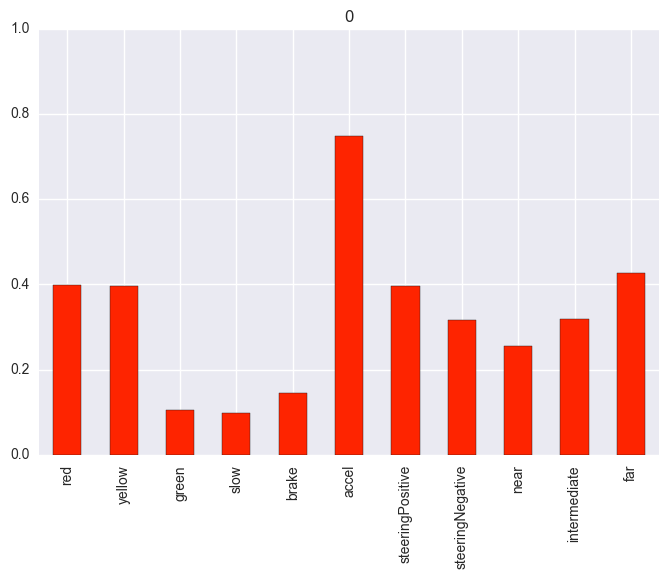

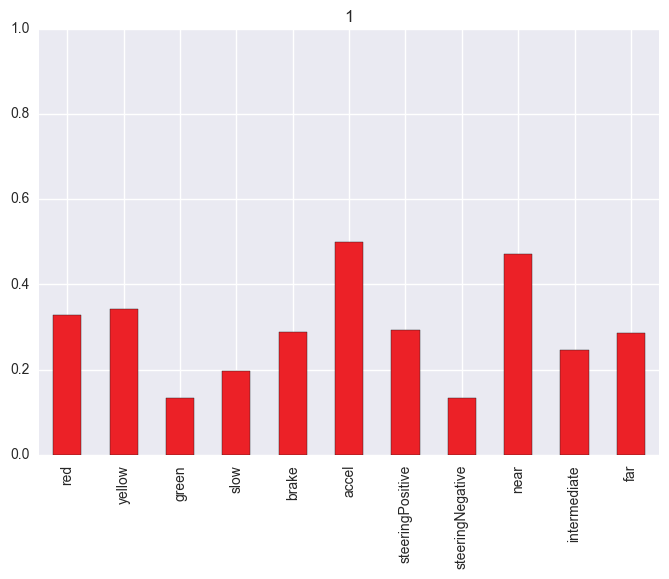

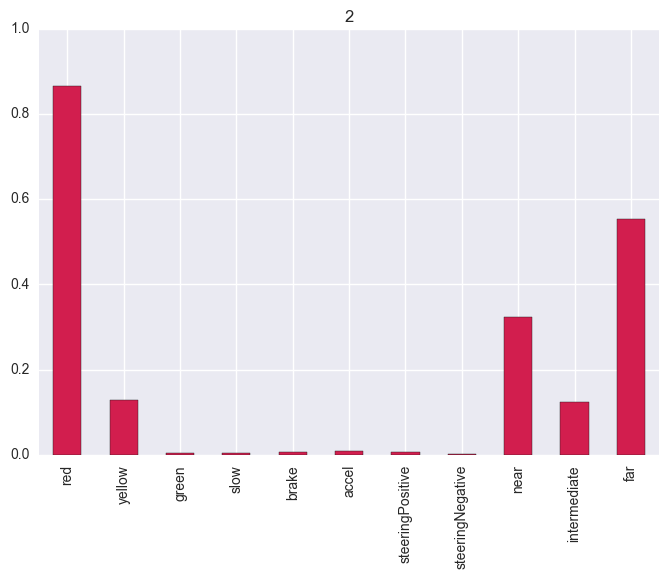

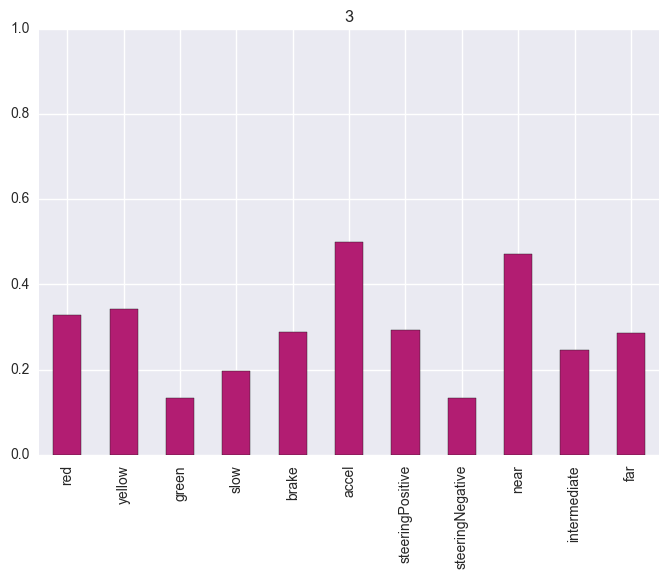

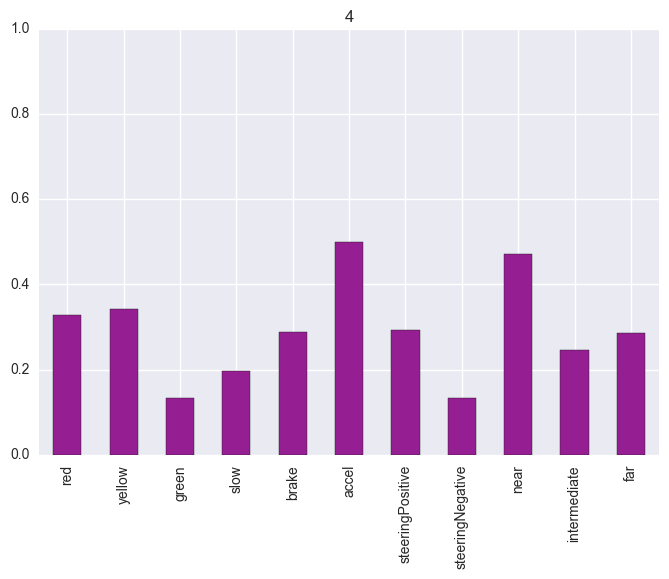

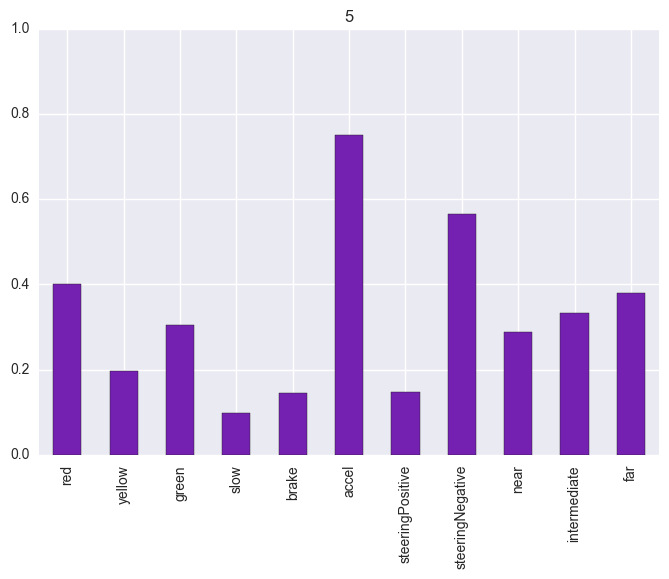

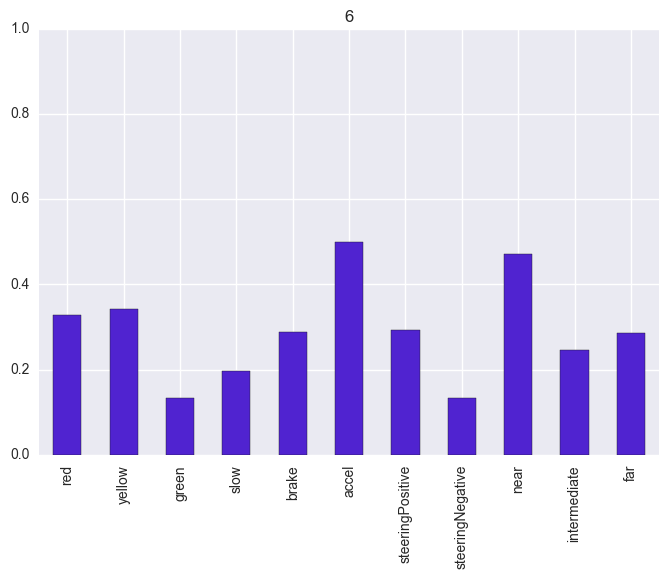

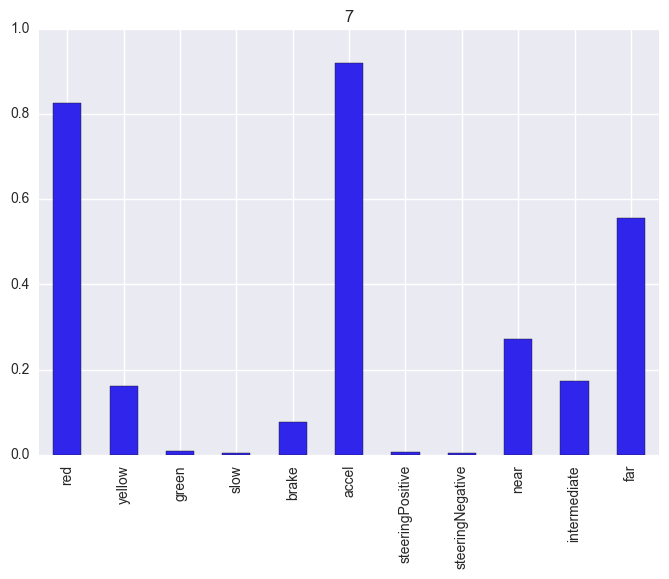

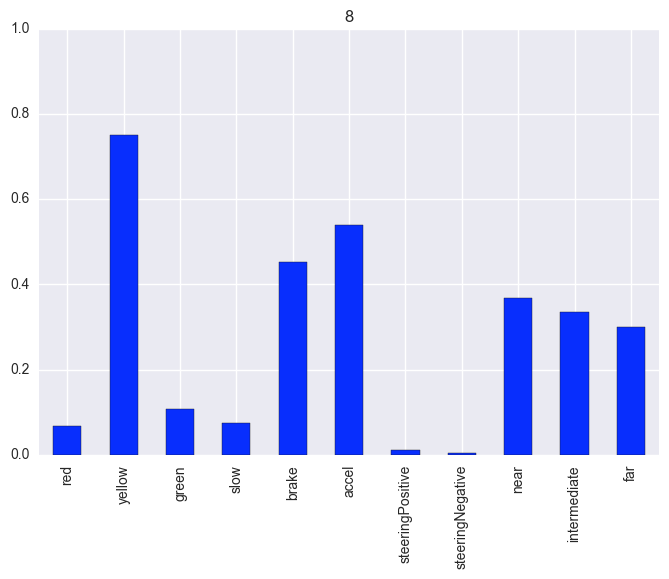

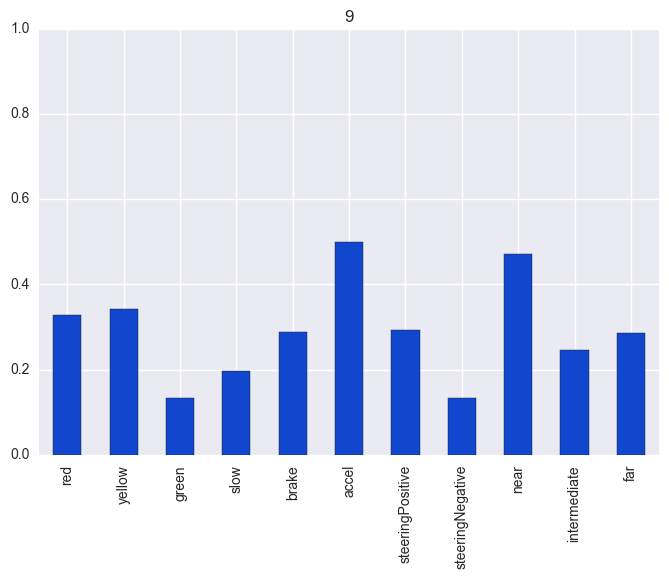

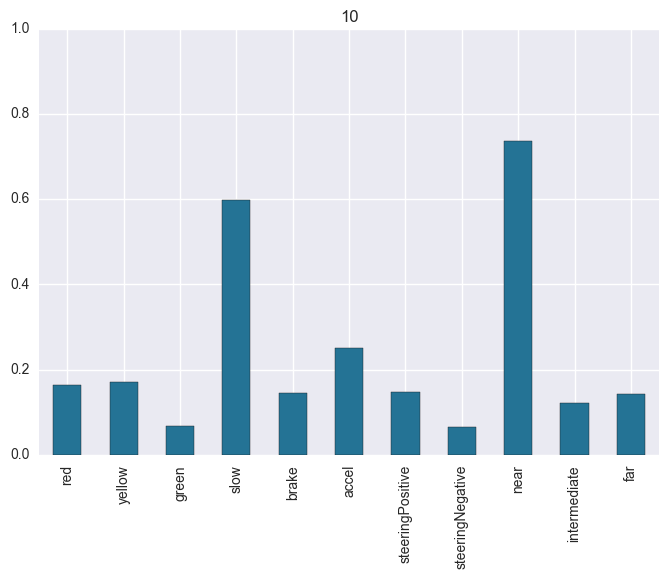

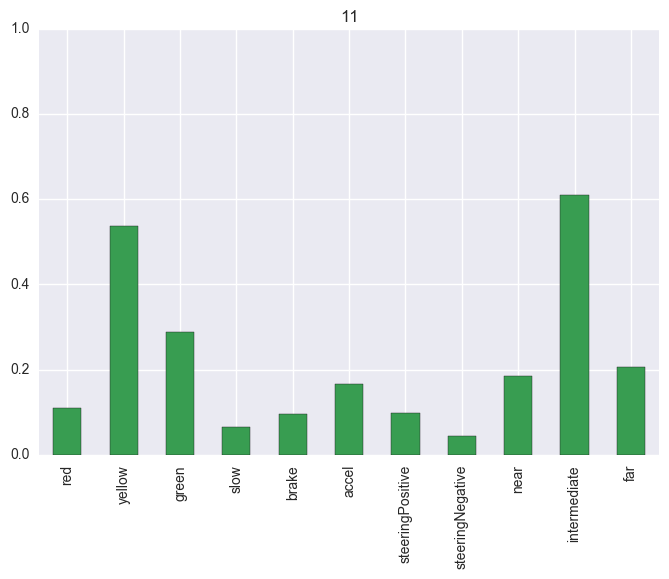

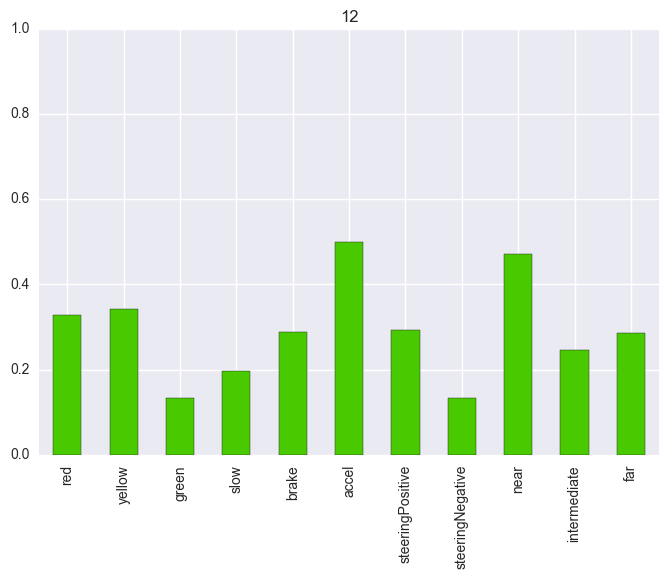

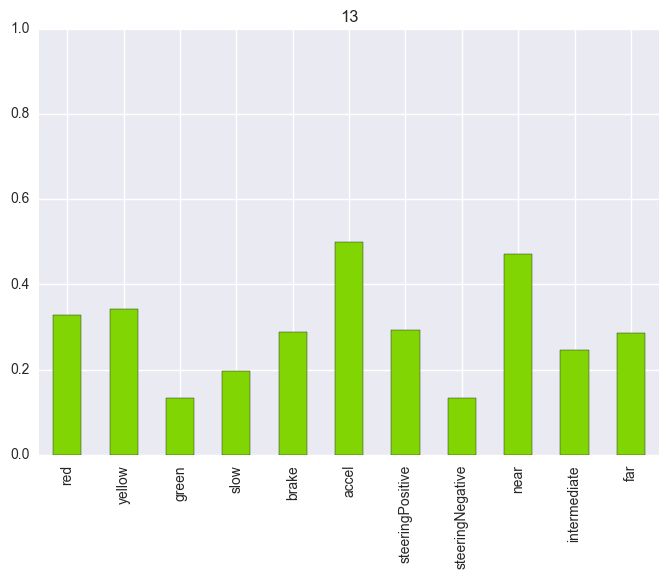

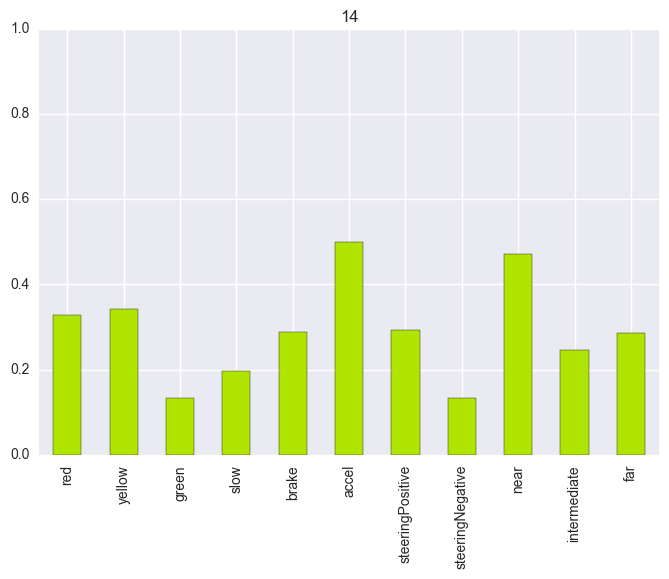

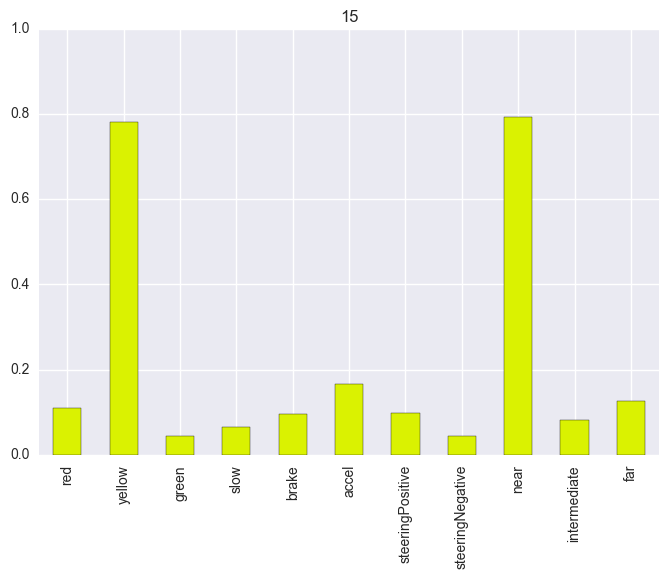

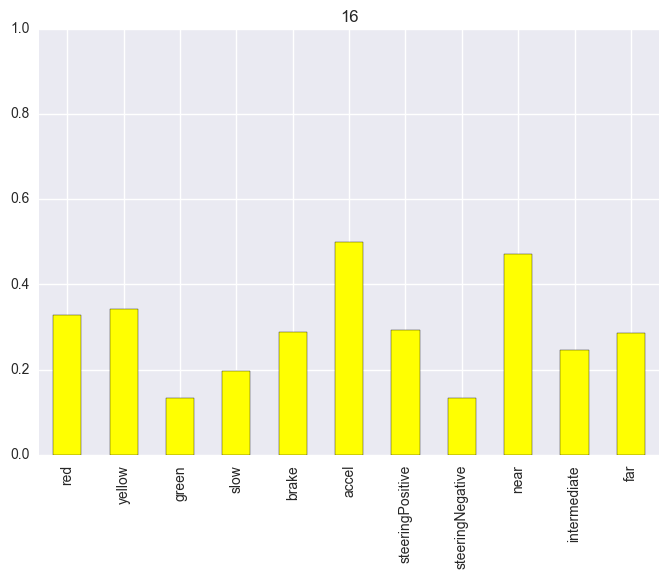

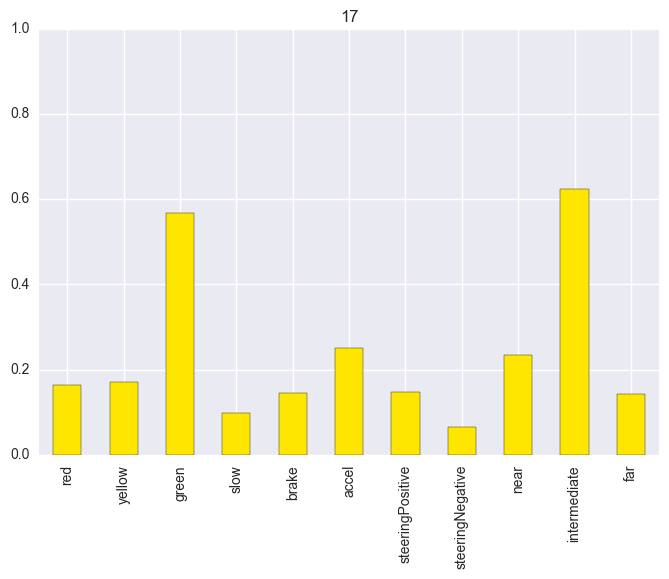

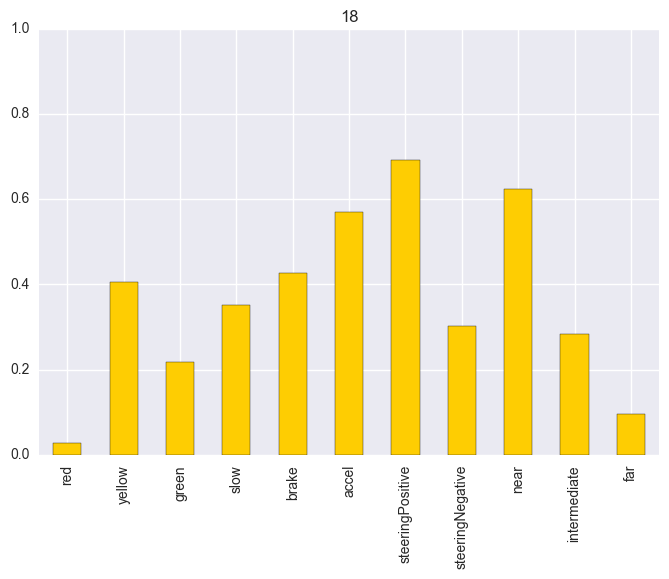

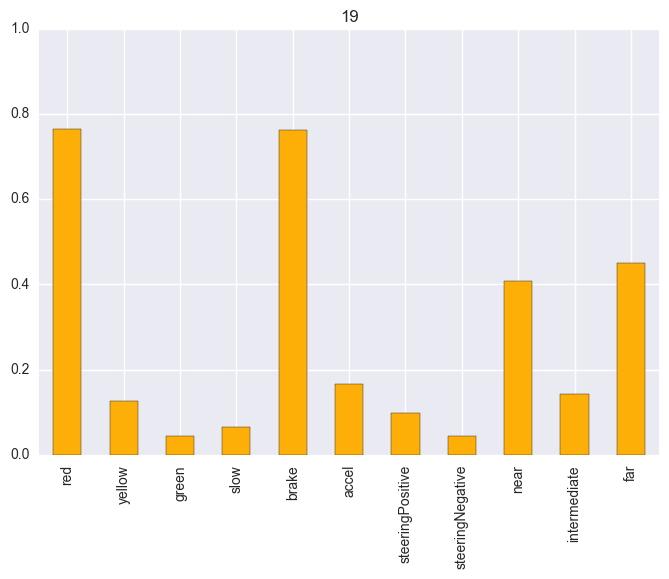

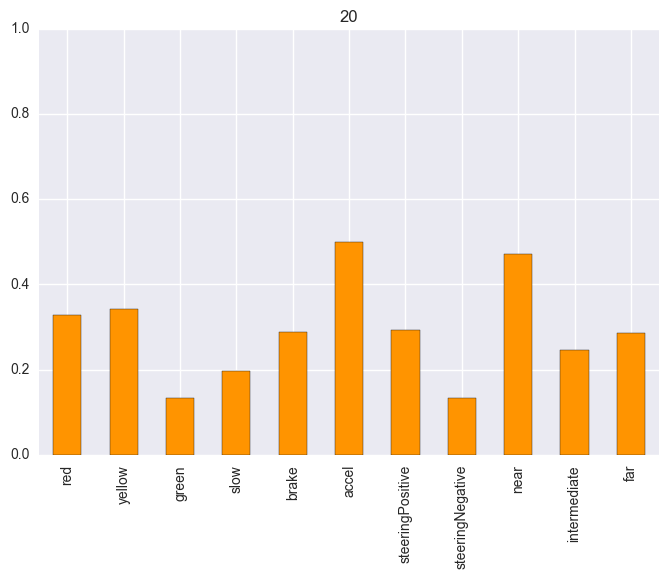

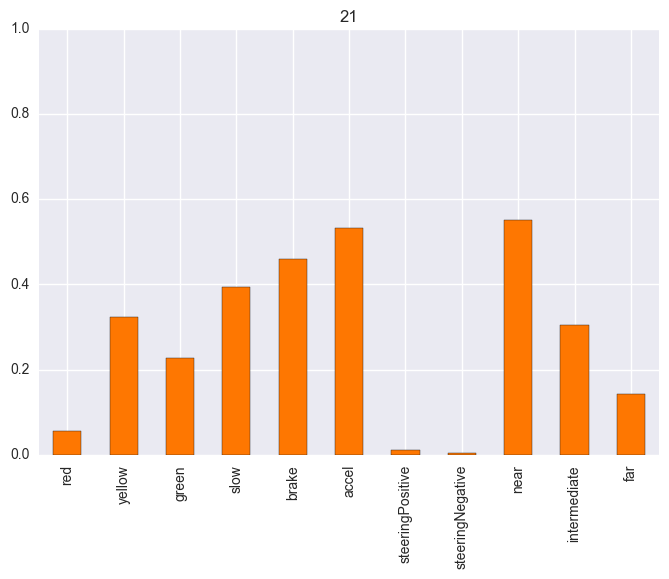

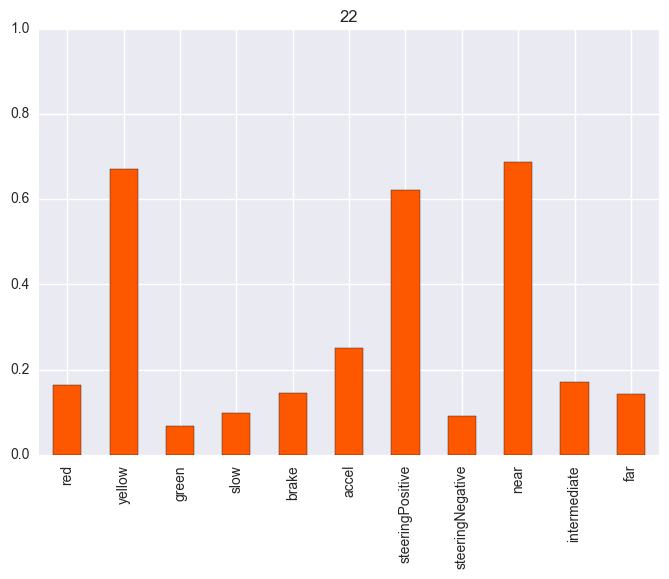

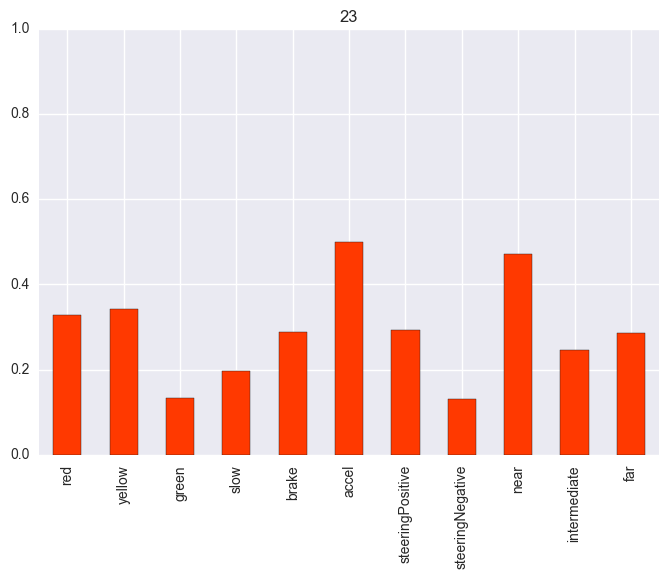

In [22]:
dir = "./img/d4/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)

ref = ref[features]
for i in range(components):
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.title(i)
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

In [ ]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)